# HbT pipeline

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 13:38:43 2023

@author: vincent chouinard
"""
import os
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.filters import threshold_local
import imageio
import sys
import imageio.v2 as imageio
from PyQt5.QtWidgets import QFileDialog, QApplication
import tifffile as tiff
from scipy import stats, ndimage
from scipy.ndimage import gaussian_filter1d, minimum_filter1d
from scipy.signal import medfilt

module_path = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis'
sys.path.insert(1,module_path)
from WFmovie import WFmovie, create_channel, regress_timeseries, save_figures_as_gif


module_path_chouine = r'/Users/vincentchouinard/Documents/GitHub/WideField'
sys.path.insert(2, module_path_chouine)
from MIFFE import *
from atlas_functions import *

2024-06-09 14:33:25.878975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**NOTE:** This notebook requires .tif green and red data for **convert_to_hb** function. If data is not already in .tif, it can be opened and saved as .tif following the **create_movies** and **generate_data_folder** pipeline.

## 1. Opens, corrects and loads data in folderpath

##### Generating path for sequential opening of datasets

In [83]:
def generate_paths(example_path, sessions, mice, formating=False, verbose=True):
    
    if formating:
        path_segments = example_path.split('/')[1:]

        for session in sessions:        
            path_segments = [segment.replace(session, '{session}') for segment in path_segments]

        for mouse in mice:
            path_segments = [segment.replace(mouse,'{mouse}') for segment in path_segments]

        example_path_format = '/'.join(path_segments)
        
    else:
        example_path_format = example_path
    
    paths = []
    # Generate paths for each combination of session and mouse
    for session in sessions:
        for mouse in mice:
            # Use string formatting to replace placeholders with actual identifiers
            new_path = example_path_format.format(session=session, mouse=mouse)
            paths.append(new_path)
            
    if verbose:
        print(paths)
            
    return paths

In [84]:
# The example_path needs to be a template for every dataset
example_path = '/Volumes/DDE_Chouine/_CVR_Dataset/{session}/Dataset/RS_{mouse}_{session}'
sessions = ['S7']
mice = ['M38']

In [85]:
# Verbose can be put to False
folderpath_list = generate_paths(example_path, sessions, mice)

['/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7']


##### Correction, opening and baseline parameters 

In [87]:
channels_exist = False            # If True: channels already exist and no need to create channels.
channels = ['green', 'red']       # 'green', 'red', 'blue', 'ir'.
data_type = 'corrected'                 # Loads corrected .tif if 'corrected', or raw data .tif if 'raw'.
hb = True                        # True means hb folder and data will be created
baseline_time = 30                # Baseline seconds at beginning of acquisition.

In [88]:
for path in tqdm(folderpath_list):
    
    movies = create_movies(path, channels = channels , channels_exist = channels_exist, stim_path = False, memmap=True)
    freq = int(movies[0].freq / movies[0].nchannels)

    if data_type == "corrected":
        for i in range(len(channels)):
            generate_data_folder(movies[i], path, channels[i], tif = True, CaImAn = True, numpy = False)
        g_path = path + "/Correction/corrected_green_movie.tif"
        r_path = path + "/Correction/corrected_red_movie.tif/"

    elif data_type == "raw":
        for i in range(len(channels)):
            generate_data_folder(movies[i], path, channels[i], tif = True, CaImAn = False, numpy = False)
        g_path = path + "/Correction/green_movie.tif"
        r_path = path + "/Correction/red_movie.tif"
        
    if hb:
        create_hb_data(g_path, r_path, path, baseline = [0 , (freq*baseline_time)])

  0%|                                                     | 0/1 [00:00<?, ?it/s]

data_path: /Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7
stim_path: False
channels: ['green', 'red']
channels_exist: False
binning: False
normalize: False
gaussian_filter: False
gaussian_std: 1
temp_med_filter: False
temp_med_width: 3
substract_background: False
background_path: None
Searching directory for uncorrected data in /Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Correction...
Calcium imaging data to correct: ['green_movie.tif']
Beginning motion correction...
Correcting green_movie.tif...


2024-06-08 17:11:15.711721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 17:11:15.711721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 17:11:15.711722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Correction/green_movie_els__d1_584_d2_673_d3_1_order_F_frames_1800.mmap



100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.22s/it]


Done!
Searching directory for uncorrected data in /Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Correction...
Calcium imaging data to correct: ['red_movie.tif']
Beginning motion correction...
Correcting red_movie.tif...


2024-06-08 17:20:50.109889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 17:20:50.125361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 17:20:50.127579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Decode mmap filename /Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M38_S7/Correction/red_movie_els__d1_584_d2_673_d3_1_order_F_frames_1800.mmap



100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.50s/it]


Done!
Directory 'Hb_data' created.



 48%|███████████████████                     | 859/1800 [00:26<00:29, 32.27it/s]


 98%|██████████████████████████████████████▏| 1760/1800 [00:50<00:01, 38.35it/s]


100%|███████████████████████████████████████████| 1/1 [28:22<00:00, 1702.27s/it]

Done! dHbO/dHbR/dHbT .tifs are now saved in Hb_data.


## Analysis

In [5]:

#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M34_18juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M35_18juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M36_18juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S1/CVR_M37_18juil/Hb_data/dHbT.tif"

#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M34_25juil/Hb_data/dHbT.tif"
#dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M35_25juil/Hb_data/dHbT.tif"
dHbT_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/S2/CVR_M37_25juil/Hb_data/dHbT.tif"


In [6]:
im = tiff.imread(dHbT_path)

In [ ]:
fig,ax = plt.subplots(figsize(8,8))
CVR_stim = np.zeros(im.shape[0])
CVR_stim[90:270] = 0.5
CVR_stim[450:630] = 0.5
CVR_stim[810:990] = 0.5
CVR_stim[1170:1350] = 1
CVR_stim[1530:1710] = 1
CVR_stim[1890:2070] = 1
time = np.linspace(0,im.shape[0]/3,im.shape[0])
ax.plot(time, CVR_stim)
ax.show()

In [9]:
def exponential(t, tau=6):
    return np.exp(-(t / tau))

In [10]:
from scipy.signal import convolve

##### (kernel needs to have the same framerate, so 3 frames by second for the time of the acquisition)

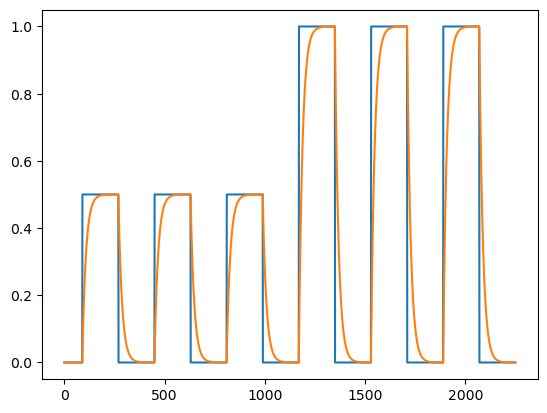

In [11]:
kernel = exponential(time)
regressor = convolve(CVR_stim, kernel)[:len(CVR_stim)]
regressor /= np.max(regressor)

plt.plot(CVR_stim)
plt.plot(regressor)

In [354]:
signal = im[:,130:150, 120:140]
signal = np.mean(signal, axis=(1,2))

In [357]:
def baseline_minfilter(signal, window=300, sigma1=5, sigma2=100, debug=False):
    signal_flatstart = np.copy(signal)
    signal_flatstart[0] = signal[1]
    smooth = gaussian_filter1d(signal_flatstart, sigma1)
    mins = minimum_filter1d(smooth, window)
    baseline = gaussian_filter1d(mins, sigma2)
    if debug:
        debug_out = np.asarray([smooth, mins, baseline])
        return debug_out
    else:
        return baseline

In [358]:
baseline = baseline_minfilter(signal, sigma1 = 7, sigma2=150)
detrended = signal-baseline

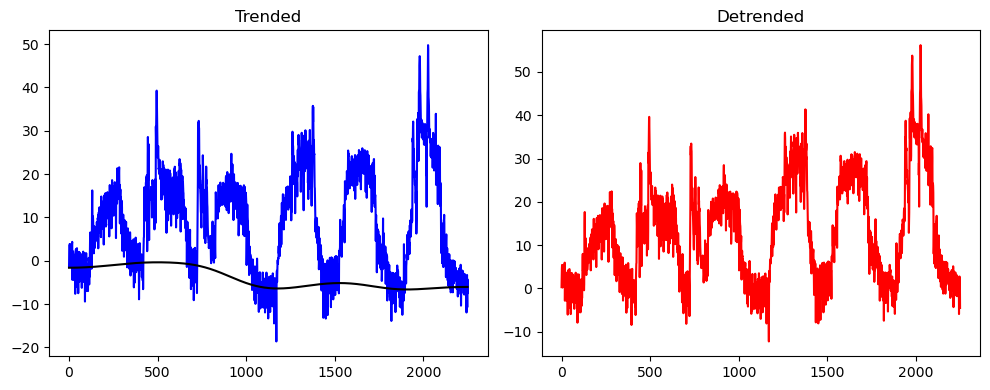

In [359]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot data on each subplot
axs[0].plot(signal, color='blue')
axs[0].plot(baseline, color='black')
axs[0].set_title('Trended')

axs[1].plot(detrended, color='red')
axs[1].set_title('Detrended')

# Display the figure with subplots
plt.tight_layout()
plt.show()

In [360]:
# def fit_signal(signal1, signal2):
#     """Fit one-dimensional signal1 to signal2 using simple inversion of a linear matrix equation.
#     Returns: fit coefficients (a, b) and fit signal a * signal1 + b."""
#     signal1 = np.expand_dims(signal1.flatten(), axis=1)  # (N x 1) vector
#     signal2 = np.expand_dims(signal2.flatten(), axis=1)  # (N x 1) vector
#     vectors = np.concatenate([signal1, np.ones((signal1.shape[0], 1))], axis=1)  # (N x 2) matrix
#     coeffs = (np.linalg.pinv(vectors) @ signal2).flatten()
#     fit = coeffs[0] * signal1 + coeffs[1]
#     return coeffs, fit

In [361]:
# coeffs, fit = fit_signal(regressor, detrended)

In [362]:
norm_detrended = detrended / np.max(detrended)

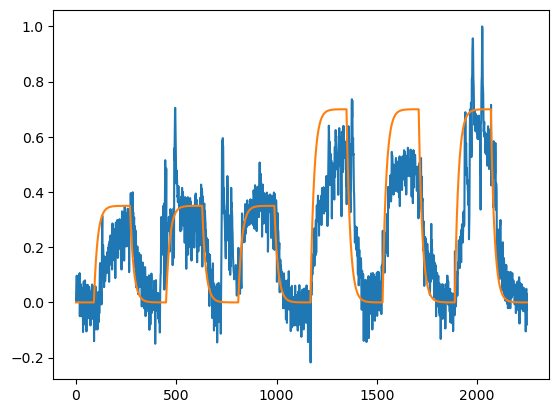

In [363]:
plt.plot(norm_detrended)
plt.plot(regressor*0.7)

In [364]:
med_filt_detrended = medfilt(norm_detrended, kernel_size=5)

# Correlation maps

In [365]:
im.shape

(2250, 280, 299)

In [366]:
corr = np.zeros((im.shape[1], im.shape[2]))
corr.shape

(280, 299)

In [367]:
for x in tqdm(range(im.shape[2])):
    for y in range(im.shape[1]):
        corr[y,x] = np.corrcoef(regressor,im[:,y,x])[0,1]

100%|█████████████████████████████████████████| 299/299 [00:13<00:00, 21.71it/s]


In [89]:
plt.imshow(corr, vmin = 0.4 , vmax = 0.9)
plt.colorbar()

NameError: name 'corr' is not defined

## Hétérogénéité potentiellement dûe au behavior . Mais, pouquoi c'est les veines sont les moins corrélées ? Intéressant

In [11]:
video_path = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil_video/CVR_M34_18juil_video.mp4"
save_path  = "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil_video/CVR_M34_18juil_video_realstart.tif"

# Motion energy

In [12]:
import numpy as np
from numba import njit

@njit
def compute_diff(current, last):
    return np.mean(np.abs((current - last) / 255 ))

In [13]:
import cv2
import tifffile as tiff
import numpy as np
from tqdm import tqdm

def motion_energy(input_file, frame_range = [0, -1]):
    
    video = cv2.VideoCapture(input_file)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_range[1] == -1:
        frame_range[1] = total_frames
        
    frame_counter = frame_range[0]
    last_frame = None
    diff = np.zeros((frame_range[1] - frame_range[0]) - 1)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        
    for i in tqdm(range(frame_range[1] - 1)):
        _, frame = video.read()

        
        current_frame = cv2.cvtColor(frame[:, 420:1500], cv2.COLOR_BGR2GRAY).astype(np.int16)
        
        if i > 0:
            diff[i-1] = np.mean(np.abs((current_frame - last_frame)/255 ))
        
        last_frame = current_frame
        frame_counter += 1
        
    video.release()
        
    return diff

In [14]:
def remove_webcam_artefacts(signal, floor):
    new_signal = np.copy(signal)
    last_index = len(signal) - 1
    for i in tqdm(np.where(signal<floor)[0]):
        if i < last_index :
            new_signal[i] = ((signal[i-1] + signal[i+1] ) / 2)
        else:
            new_signal[i] = new_signal[i-1]
    return new_signal

In [15]:
diff = motion_energy(video_path)

OpenCV: Couldn't read video stream from file "/Users/vincentchouinard/Documents/Maitrise/Data/_CVR_dataset/CVR_M34_18juil_video/CVR_M34_18juil_video.mp4"


ValueError: negative dimensions are not allowed

In [16]:
filt_diff = remove_webcam_artefacts(diff, 0.006)

NameError: name 'diff' is not defined

# CVR maps

In [26]:
five_stim = CVR_stim[:1170]
five_stim[ five_stim > 0] = 1
five_stim.astype(np.int8)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [29]:
ten_stim = CVR_stim[1170:]
ten_stim[ ten_stim > 0] = 1
ten_stim.astype(np.int8)

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [31]:
def mean_response(arr, binary_arr):
    """
    Compute the mean of a 3D axis along the T-axis, considering only the elements where the binary array is equal to 1.

    Args:
        arr (numpy.ndarray): The 3D array of shape (T, M, N).
        binary_arr (numpy.ndarray): The binary array of shape (T,) indicating which elements to consider.

    Returns:
        numpy.ndarray: The mean along the T-axis, considering only the elements where binary array is equal to 1.
    """
    mask = binary_arr[:, np.newaxis, np.newaxis] != 0.0
    masked_arr = np.where(mask, arr, np.nan)
    mean = np.nanmean(masked_arr, axis=0)

    return mean

In [66]:
five_response = mean_response(im[:len(five_stim)], five_stim)
ten_response = mean_response(im[len(five_stim):], ten_stim)

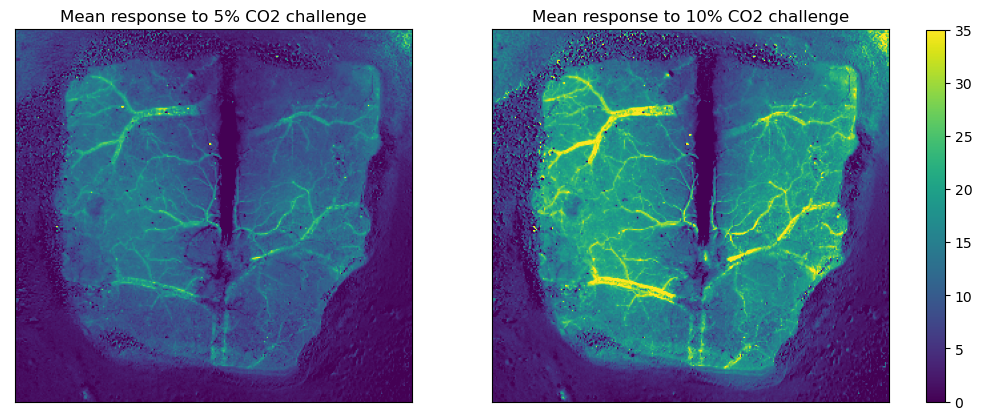

In [95]:
# Define your limits
vmin, vmax = 0, 35

fig, ax = plt.subplots(1,2,figsize=(12,6))
im1 = ax[0].imshow(five_response, vmin=vmin, vmax=vmax)
im2 = ax[1].imshow(ten_response, vmin=vmin, vmax=vmax)

ax[0].set_title("Mean response to 5% CO2 challenge")
ax[1].set_title("Mean response to 10% CO2 challenge")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

# Add a single colorbar for both images
cbar = fig.colorbar(im2, ax=ax, fraction=0.02, pad=0.04)

plt.show()

# Tests on regions

In [3]:
dHbT = tiff.imread('/Volumes/DDE_Chouine/M38_forepaw_13fev/Hb_data/dHbT.tif')
mask_folder_path = '/Volumes/DDE_Chouine/M38_forepaw_13fev/Masks'

In [4]:
dHbT.shape

(630, 317, 334)

In [5]:
dHbT = tiff.imread('/Volumes/DDE_Chouine/M38_forepaw_13fev/Hb_data/dHbT.tif')
mask_folder_path = '/Volumes/DDE_Chouine/M38_forepaw_13fev/Masks'
files = identify_files(mask_folder_path, 'mask_')

id_list = [int(name.split('_')[1].split('.')[0]) for name in files]
id_list.sort()
sorted_files = [f'mask_{id}.tif' for id in id_list]

def bin_pixels(frame, bin_size):
    height, width = frame.shape[:2]
    binned_height = height // bin_size
    binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)
    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    return binned_frame

timeseries = np.zeros((len(sorted_files), dHbT.shape[0]))
for i, mask_name in enumerate(sorted_files):
    mask = tiff.imread(mask_folder_path + '/' + mask_name)
    binned_mask = bin_pixels(mask, 2)
    mean_response = np.mean(binned_mask*dHbT, axis=(1,2))
    timeseries[i, :] = mean_response
    
from matplotlib.font_manager import FontProperties

def plot_timeseries(ts_stack, id_list):
    fig, ax = plt.subplots(figsize=(12,8), dpi = 120)
    n_ts = ts_stack.shape[0]
    height = 0
    font = FontProperties(family='Times New Roman', weight='bold', size=12)
    
    for i in range(n_ts):
        plt.plot(ts_stack[i,:] + height, '-k')
        plt.text(-30, ts_stack[i, :][0] + height, str(id_list[i]) + ' ', fontproperties=font, va='center', ha='right')
        height += 2.4
    plt.yticks([])
    

In [ ]:
{68: 'Frontal pole, layer 1',
 97: 'Temporal association areas, layer 1',
 171: 'Prelimbic area, layer 1',
 281: 'Anteromedial visual area, layer 1',
 320: 'Primary motor area, Layer 1',
 421: 'Lateral visual area, layer 1',
 442: 'Retrosplenial area, dorsal part, layer 1',
 450: 'Primary somatosensory area, upper limb, layer 1',
 484: 'Orbital area, medial part, layer 1',
 527: 'Dorsal auditory area, layer 1',
 542: 'Retrosplenial area, ventral part, layer 1',
 558: 'Primary somatosensory area, nose, layer 1',
 593: 'Primary visual area, layer 1',
 656: 'Secondary motor area, layer 1',
 671: 'Retrosplenial area, lateral agranular part, layer 1',
 696: 'Posterior auditory area, layer 1',
 735: 'Primary auditory area, layer 1',
 750: 'Posterolateral visual area, layer 1',
 805: 'posteromedial visual area, layer 1',
 836: 'Ectorhinal area/Layer 1',
 873: 'Supplemental somatosensory area, layer 1',
 878: 'Primary somatosensory area, mouth, layer 1',
 897: 'Visceral area, layer 1',
 935: 'Anterior cingulate area, dorsal part, layer 1',
 959: 'Ventral auditory area, layer 1',
 981: 'Primary somatosensory area, barrel field, layer 1',
 1006: 'Primary somatosensory area, trunk, layer 1',
 1030: 'Primary somatosensory area, lower limb, layer 1',
 1074: 'Anterolateral visual area, layer 1',
 182305693: 'Primary somatosensory area, unassigned, layer 1',
 312782550: 'Anterior area, layer 1',
 312782578: 'Laterointermediate area, layer 1',
 312782604: 'Rostrolateral area, layer 1',
 312782632: 'Postrhinal area, layer 1'}

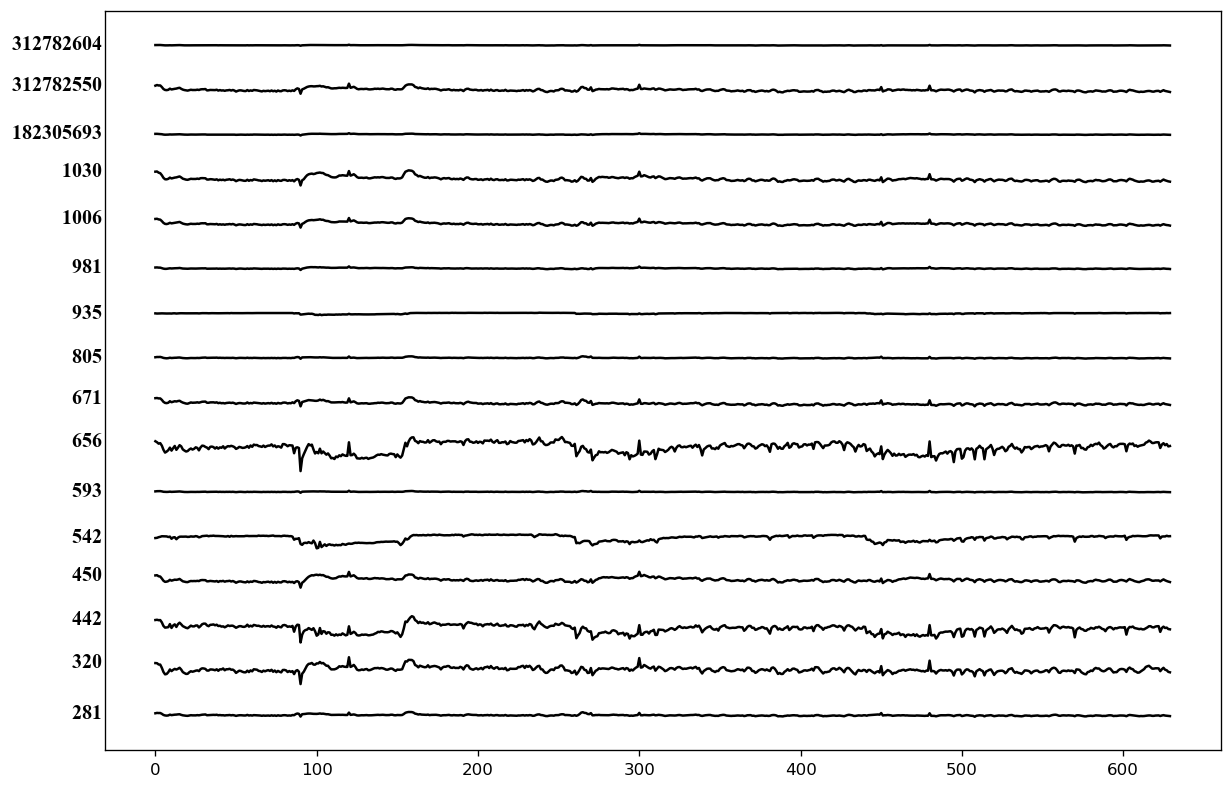

In [14]:
plot_timeseries(timeseries, id_list)

In [59]:
import numpy as np
stims1 = [(45, 225), (225, 405), (405, 585)]
stims2 = [(45, 225), (225, 405), (405, 585), (585,765), (765,945)]

def mean_responses(timeseries, stims):
    mean_responses = np.zeros((len(stims), 180))
    
    for i, (start, end) in enumerate(stims):
        response = timeseries[start:end]
        mean_responses[i, :] = response
    
    mean = np.mean(mean_responses, axis=0)
    
    return mean

In [62]:
fore = gaussian_filter1d(mean_responses(timeseries[3],stims1),sigma=1)
lower = gaussian_filter1d(mean_responses(timeseries[12],stims1),sigma=1)
whisk = gaussian_filter1d(mean_responses(timeseries[10],stims1),sigma=1)

In [71]:
fore[125:] += -0.05

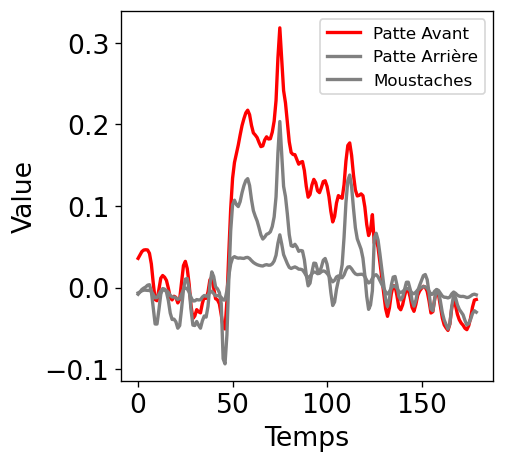

In [81]:
fig,ax=plt.subplots(figsize=(4,4),dpi=120)

# Plotting the data
#plt.plot(fore, linewidth=2, label='Patte Avant')  # Add label for legend
plt.plot(fore, linewidth=2, label='Patte Avant', color='red')
plt.plot(lower, linewidth=2, label='Patte Arrière', color='grey')
plt.plot(whisk, linewidth=2, label='Moustaches', color='grey')


# Customizing font sizes for labels and ticks
font_size = 16  # You can change this value as needed
plt.xlabel('Temps', fontsize=font_size)
plt.ylabel('Value', fontsize=font_size)
plt.xticks([0, 60, 120, 180], [0, 10, 20, 30] fontsize=font_size)
plt.yticks(fontsize=font_size)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

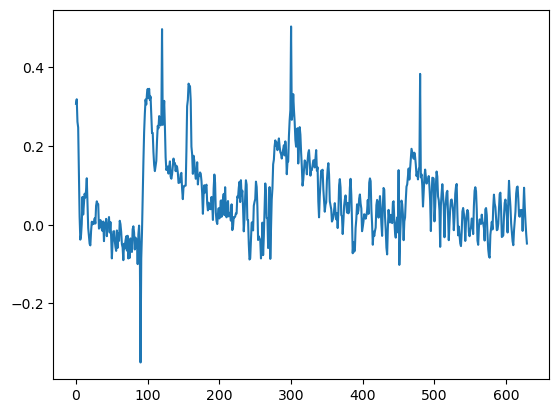

In [21]:
plt.plot(timeseries[3])

In [14]:
dHbT = tiff.imread('/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M35_S7/Hb_data/dHbT.tif')
dHbT2 = tiff.imread('/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/RS_M37_S7/Hb_data/dHbT.tif')
#60:400

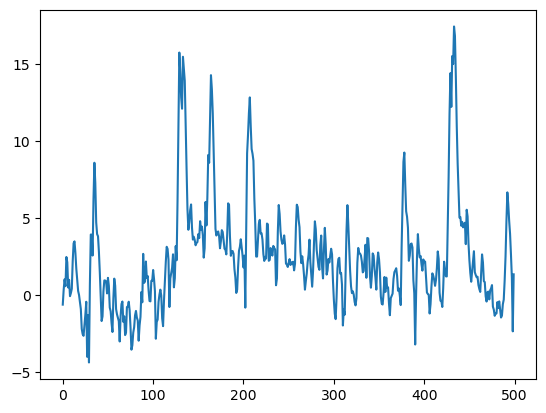

In [20]:
plt.plot(np.mean(dHbT2[0:500,125:175,75:125],axis=(1,2)))

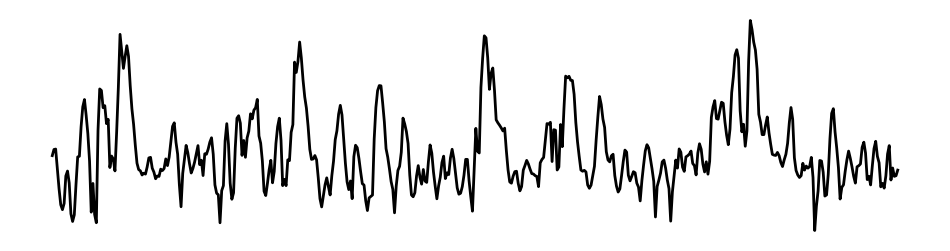

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming dHbT is already defined
data = np.mean(dHbT[1250:1750, 125:175, 50:100], axis=(1, 2))

# Generate time points (or indices) for the data
time_points = np.arange(len(data)).reshape(-1, 1)

# Perform linear regression to estimate the trend
model = LinearRegression()
model.fit(time_points, data)
trend = model.predict(time_points)

# Remove the linear trend from the data
detrended_data = data - trend

# Plot the corrected signal
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(detrended_data, linewidth=2, color='black')

# Remove axes and frame
ax.axis('off')

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Colloque/hbt_signal_1.svg')

# Mask measurements

In [23]:
files = identify_files(mask_folder_path, 'mask_')
mask_folder_path = '/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout/Masks'
for i in range(len(files)):
    mask = tiff.imread(mask_folder_path + '/' + files[i])
    if i==0:
        masks = np.zeros((len(files),mask.shape[0],mask.shape[1]))
    masks[i] = mask

In [29]:
def region_size(mask):
    
    # Count the number of 1's
    count_ones = np.sum(mask == 1)
    return count_ones

In [37]:
sizes = []
for i in range(len(files)):
    sizes.append(region_size(masks[i])/10000)

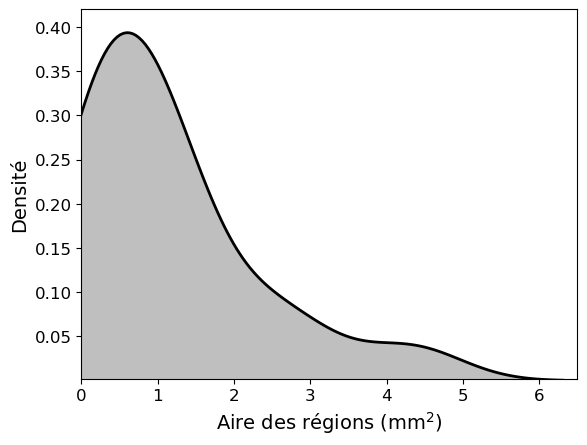

In [71]:

import matplotlib.pyplot as plt
import seaborn as sns

# Given values
values = [
    1.3241, 0.2437, 0.386, 0.3578, 0.1822, 0.6336, 1.3479, 2.7975, 2.4199,
    4.3233, 1.1552, 0.2075, 1.1498, 0.1184, 0.4026, 0.9824
]

# Create a KDE plot
sns.kdeplot(values, fill=True, color='black', linewidth=2)

# Add titles and labels with increased font size
#plt.title('Kernel Density Estimation of Given Values', fontsize=16)
plt.xlabel(r'Aire des régions ($\mathrm{mm}^2$)', fontsize=14)
plt.ylabel('Densité', fontsize=14)

# Increase the size of tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, 6.5])
plt.ylim([0.002,0.42])

# Display the plot
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Colloque/region_density.svg')